# Gabor layer experiment

> In this quick experiment we will be training an MNIST classifier using multiple `GaborLayer` layers.

In [1]:
#| hide
%load_ext autoreload
%autoreload 2

## Library importing

In [2]:
#| hide
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

from flayers.layers import GaborLayer

## Data loading

> We will be using MNIST for a simple and quick test.

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = repeat(X_train, "b h w ->  b h w c", c=1)/255.0
X_test = repeat(X_test, "b h w ->  b h w c", c=1)/255.0

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

## Definition of simple model

In [5]:
n_gabors = 4
sigma_i = [0.1, 0.2, 0.1, 0.1]
sigma_j = [0.2, 0.1, 0.2, 0.2]
freq = [10, 10]*2
theta = [0, np.pi/2, np.pi/4, -np.pi/4]
rot_theta = [0, 0]*2
sigma_theta = [0, 0, np.pi/4, -np.pi/4]

In [6]:
model = tf.keras.Sequential([
    GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
               theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
               theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20),
    layers.MaxPool2D(2),
    GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
               theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

2022-09-08 10:34:16.837755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10793 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:03:00.0, compute capability: 3.5


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gabor_layer (GaborLayer)     (None, 28, 28, 4)         26        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
gabor_layer_1 (GaborLayer)   (None, 14, 14, 4)         26        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
gabor_layer_2 (GaborLayer)   (None, 7, 7, 4)           26        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 4)           0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0

We can show the initial Gabor filters:

2022-09-08 10:34:20.497150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-08 10:34:20.716222: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x55ce0961be70


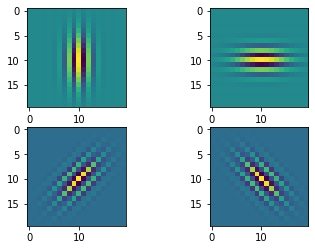

In [7]:
model.layers[0].show_filters()

In [8]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_split=0.2)

Epoch 1/100


2022-09-08 10:34:35.055817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-09-08 10:34:35.517682: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


375/375 [==============================] - 48s 93ms/step - loss: 53.1879 - accuracy: 0.1049 - val_loss: 7.3154 - val_accuracy: 0.1034
Epoch 2/100
375/375 [==============================] - 32s 86ms/step - loss: 5.3019 - accuracy: 0.1095 - val_loss: 3.9903 - val_accuracy: 0.1092
Epoch 3/100
375/375 [==============================] - 32s 84ms/step - loss: 3.3966 - accuracy: 0.1096 - val_loss: 2.9894 - val_accuracy: 0.1128
Epoch 4/100
375/375 [==============================] - 32s 85ms/step - loss: 2.8143 - accuracy: 0.1138 - val_loss: 2.6610 - val_accuracy: 0.1093
Epoch 5/100
375/375 [==============================] - 31s 83ms/step - loss: 2.6076 - accuracy: 0.1096 - val_loss: 2.5345 - val_accuracy: 0.1093
Epoch 6/100
375/375 [==============================] - 32s 84ms/step - loss: 2.5094 - accuracy: 0.1115 - val_loss: 2.4872 - val_accuracy: 0.1034
Epoch 7/100
375/375 [==============================] - 32s 85ms/step - loss: 2.4797 - accuracy: 0.1102 - val_loss: 2.4527 - val_accuracy: 0.1

Showing the training dynamics:

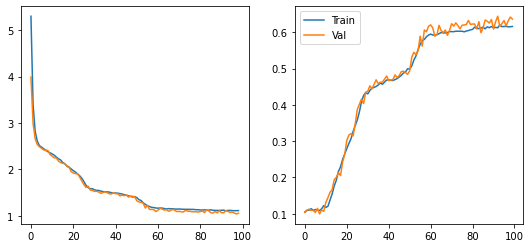

In [22]:
fig, axes = plt.subplots(1,2, figsize=(9,4))
axes[0].plot(history.history['loss'][1:], label="Train")
axes[0].plot(history.history['val_loss'][1:], label="Val")
axes[1].plot(history.history['accuracy'], label="Train")
axes[1].plot(history.history['val_accuracy'], label="Val")
plt.legend()
plt.show()

Calculate the metrics in the test set:

In [13]:
model.evaluate(X_test, Y_test, batch_size=128)

79/79 [==============================] - 3s 36ms/step - loss: 1.0928 - accuracy: 0.6304


[1.0928494930267334, 0.6304000020027161]

We can visualize the gabor filters after the training process:

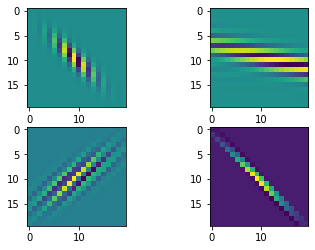

In [14]:
model.layers[0].show_filters()

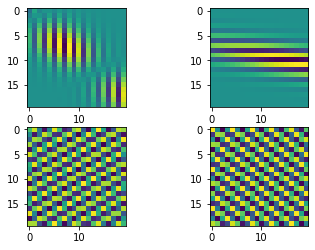

In [15]:
model.layers[2].show_filters()

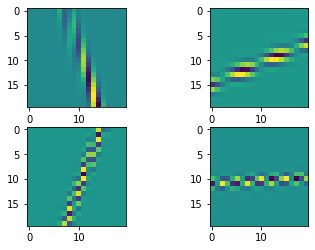

In [16]:
model.layers[4].show_filters()

We can even check the atributes of the layer to inspect the change in the initial parameters:

In [17]:
model.layers[0].theta.numpy()*180/np.pi

array([  0.38321877,  90.76502   ,  45.756405  , -47.088924  ],
      dtype=float32)

In [18]:
model.layers[0].rot_theta.numpy()*180/np.pi

array([ 0.39840868, -0.8525029 , -0.04723335, -1.0895499 ], dtype=float32)

In [19]:
model.layers[0].sigma_theta.numpy()*180/np.pi

array([-45.138485,   9.870471,  55.021404, -44.676727], dtype=float32)